In [1]:
from utils.consts import * ## const variables are there, so paths and extraction features ##
from utils. plotting import * ## plotting ##
from data_reader_babalit import * ## the class which reads balabit dataset ##
from data_reader_chaoshen import * ## the class which reads chaoshen datasets TODO There are several issues with this dataset -> explained later ##
from legality_analyser import * ## the class which analyses the datasets with 0 1 labels --> splitting samples is being done there ##  
import random
from nonlegality_analyser import * ## the class which analyses the datasets without 0 1 labels --> splitting samples is being done there ##  


from custom_dataset import *
from VAEmodel import *

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve, auc

from torch.utils.data import  DataLoader
from torchvision import transforms
from neural_data_creator import *




## Creating dataset

In [37]:

## Specyfing the USERS ## 
users = [7,9,15,16,20,21,23,29, 35]
## Creating the object which analyses the dataset ## 
balabit_reader = DataReaderBalabit(BALABIT, users, False) ## the arguments are DATASET, users, supervised, how many records should be procesed ##
balabit_reader.processDataWithoutLabels() ## creating the data without labels ##
## getting path from the reader ##
path = balabit_reader.getFileName()

## creating analyser class ## 
balabitAnalyser = nonLegalityAnalyser(path)
## counting how many actions were extracted ## 
print(balabitAnalyser.countActions())



File already exist
type_of_action     1     3     4
userid                          
7               3885  4090   695
9               2473  2580   288
15              3332  4796   639
16              5231  6681  1450
20              3297  2723   333
21              3383  3161   528
23              2519  3927   307
29              2683  4871   938
35              2927  2401   380


Dataset Variables

In [38]:
test_ratio = 0.2
threshold_ratio = 0.1
trueUser = 7
dataset = balabitAnalyser.createTrainingDataWithLabel(trueUser)
neuralDataCreator = NeuralDataCreator(dataset)
x_training, y_training, x_validation, y_validation, x_threshold_positive, x_threshold_negative, y_threshold, x_test, y_test = neuralDataCreator.create_data(test_ratio, threshold_ratio)

In [39]:
training_dataset, validation_dataset,treshold_dataset_positive, treshold_dataset_negative , test_dataset = neuralDataCreator.create_datasets(x_training, x_validation , x_threshold_positive, x_threshold_negative, x_test)

In [40]:
input_size = 39  
hidden_size = 128
latent_size = 10
learning_rate = 1e-5

In [42]:
## CREATING DATALOADERS ##

training_loader = DataLoader(training_dataset, batch_size=16, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False)
threshold_loader_positive = DataLoader(treshold_dataset_positive, batch_size=8, shuffle=False)
threshold_loader_negative = DataLoader(treshold_dataset_negative, batch_size=8, shuffle=False)

test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

## Model || Learning loop

In [43]:
model = VAE(input_size, hidden_size, latent_size, learning_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

weight = 0.5

# Optimizer
num_epochs = 100
for epoch in range(num_epochs):
    for batch in training_loader:
        model.train()  # Set the model to training mode
        kl_weight = min(epoch / (num_epochs/3), 1.0)
        # kl_weight = 1

        x = batch.to(device)
        x = x.view(-1, input_size)

        # Forward pass
        loss = model.train_step(x, weight, kl_weight)

   
    # Validation phase
    model.eval()
    with torch.no_grad():
        total_validation_loss = 0.0
        num_validation_batches = 0

        for batch in validation_loader:
            x_val = batch.to(device)
            x_val = x_val.view(-1, input_size)
            reconstruction_val, mu_val, log_var_val = model(x_val)
            validation_loss = model.compute_loss(reconstruction_val, x_val, mu_val, log_var_val, weight, kl_weight)

            total_validation_loss += validation_loss.item()
            num_validation_batches += 1

    average_validation_loss = total_validation_loss / num_validation_batches

    # Print the loss at the end of each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss:.4f}, Validation Loss: {average_validation_loss:.4f}')


Epoch [1/100], Training Loss: 50.1759, Validation Loss: 110.6038
Epoch [2/100], Training Loss: 33.7790, Validation Loss: 80.2649
Epoch [3/100], Training Loss: 21.5772, Validation Loss: 57.3801
Epoch [4/100], Training Loss: 13.5551, Validation Loss: 43.8565
Epoch [5/100], Training Loss: 13.4440, Validation Loss: 38.6617
Epoch [6/100], Training Loss: 13.5994, Validation Loss: 36.2554
Epoch [7/100], Training Loss: 13.9379, Validation Loss: 34.8690
Epoch [8/100], Training Loss: 10.8889, Validation Loss: 33.8811
Epoch [9/100], Training Loss: 10.6944, Validation Loss: 32.4964
Epoch [10/100], Training Loss: 10.1240, Validation Loss: 31.3255
Epoch [11/100], Training Loss: 10.0135, Validation Loss: 30.1305
Epoch [12/100], Training Loss: 10.6070, Validation Loss: 29.3717
Epoch [13/100], Training Loss: 8.8565, Validation Loss: 28.6336
Epoch [14/100], Training Loss: 9.1251, Validation Loss: 28.1554
Epoch [15/100], Training Loss: 8.5426, Validation Loss: 27.8599
Epoch [16/100], Training Loss: 8.301

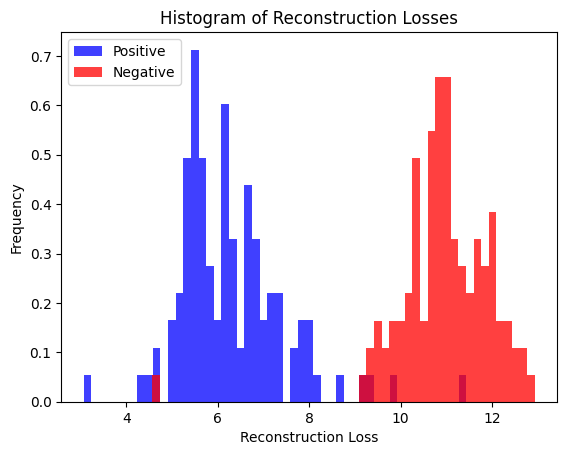

In [45]:
# Assuming you have separate DataLoader for negative test data (test_negative_loader)
reconstruction_losses_positive = []
reconstruction_losses_negative = []

model.eval()
with torch.no_grad():
    # Evaluate on positive test data
    for batch in threshold_loader_positive:
        x_test = batch.to(device)
        x_test = x_test.view(-1, input_size)
        reconstruction_test, mu_test, log_var_test = model(x_test)
        test_loss = model.compute_reconstruction_loss(reconstruction_test, x_test)
        reconstruction_losses_positive.append(test_loss.item())
    # Evaluate on negative test data
    for batch in threshold_loader_negative:
        x_test = batch.to(device)
        x_test = x_test.view(-1, input_size)
        reconstruction_test, mu_test, log_var_test = model(x_test)
        test_loss = model.compute_reconstruction_loss(reconstruction_test, x_test)
        reconstruction_losses_negative.append(test_loss.item())

# Plot histograms for both positive and negative test data
plt.hist(reconstruction_losses_positive, bins=50, density=True, alpha=0.75, color='blue', label='Positive')
plt.hist(reconstruction_losses_negative, bins=50, density=True, alpha=0.75, color='red', label='Negative')
plt.xlabel('Reconstruction Loss')
plt.ylabel('Frequency')
plt.title('Histogram of Reconstruction Losses')
plt.legend()
plt.show()

mean_positive = np.mean(reconstruction_losses_positive)
mean_negative = np.mean(reconstruction_losses_negative)

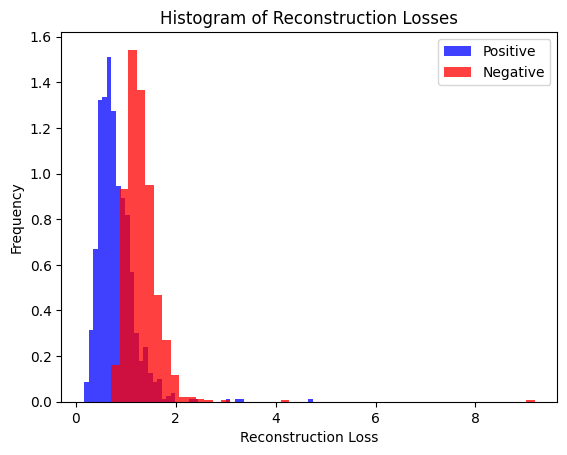

In [30]:
# Assuming you have separate DataLoader for negative test data (test_negative_loader)
reconstruction_losses_positive = []
reconstruction_losses_negative = []

model.eval()

with torch.no_grad():
    # Evaluate on positive test data
    for batch in threshold_loader_positive:
        x_test = batch.to(device)
        x_test = x_test.view(-1, input_size)
        reconstruction_test, mu_test, log_var_test = model(x_test)
        test_loss = model.compute_loss(reconstruction_test, x_test, mu_test, log_var_test, weight, kl_weight)
        reconstruction_losses_positive.append(test_loss.item())

    # Evaluate on negative test data
    for batch in threshold_loader_negative:
        x_test = batch.to(device)
        x_test = x_test.view(-1, input_size)
        reconstruction_test, mu_test, log_var_test = model(x_test)
        test_loss = model.compute_loss(reconstruction_test, x_test, mu_test, log_var_test, weight, kl_weight)
        reconstruction_losses_negative.append(test_loss.item())

# Plot histograms for both positive and negative test data
plt.hist(reconstruction_losses_positive, bins=50, density=True, alpha=0.75, color='blue', label='Positive')
plt.hist(reconstruction_losses_negative, bins=50, density=True, alpha=0.75, color='red', label='Negative')
plt.xlabel('Reconstruction Loss')
plt.ylabel('Frequency')
plt.title('Histogram of Reconstruction Losses')
plt.legend()
plt.show()

mean_positive = np.mean(reconstruction_losses_positive)
mean_negative = np.mean(reconstruction_losses_negative)

## THRESHOLD FINDING ##

In [31]:
model.eval()
artificial_labels  = []
with torch.no_grad():
    total_validation_loss = 0.0
    num_validation_batches = 0
    validation_losses = []

    for batch in threshold_loader_positive:
        x_val = batch.to(device)
        x_val = x_val.view(-1, input_size)
        reconstruction_val, mu_val, log_var_val = model(x_val)
        validation_loss = model.compute_loss(reconstruction_val, x_val, mu_val, log_var_val, weight, kl_weight)
        validation_losses.append(validation_loss.item())
        total_validation_loss += validation_loss.item()
        num_validation_batches += 1
        artificial_labels.append(0)

    average_validation_loss = total_validation_loss / num_validation_batches

    # Calculate F1-score on the validation set using the data-driven threshold
    
    # Print the loss and F1 score at the end of each epoch
    for batch in threshold_loader_negative:
            x_val = batch.to(device)
            x_val = x_val.view(-1, input_size)
            reconstruction_val, mu_val, log_var_val = model(x_val)
            validation_loss = model.compute_loss(reconstruction_val, x_val, mu_val, log_var_val, weight, kl_weight)
            validation_losses.append(validation_loss.item())
            total_validation_loss += validation_loss.item()
            num_validation_batches += 1
            artificial_labels.append(1)

    num_samples = num_validation_batches



    thresholds = np.linspace(min(validation_losses), max(validation_losses), 100)
    f1_scores = [f1_score(y_threshold, validation_losses < t) for t in thresholds]
    # f1_scores = [f1_score(y_artificial_lab, validation_losses > t) for t in thresholds]

    optimal_threshold = thresholds[np.argmax(f1_scores)]
    print(f'F1-Score: {max(f1_scores):.4f}, Optimal Threshold: {optimal_threshold:.4f}')

F1-Score: 0.8133, Optimal Threshold: 0.9820


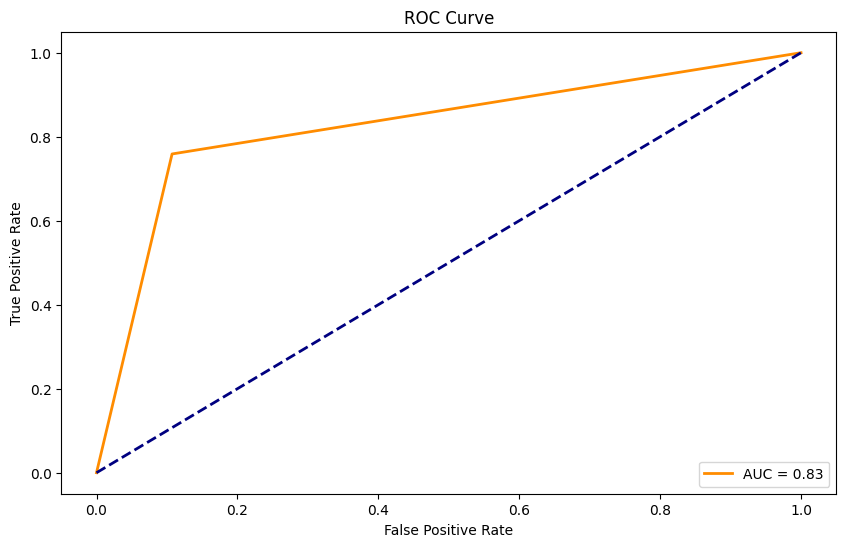

In [32]:
## USE OPTIMAL THRESHOLD TO CALCULATE ROC AUC ## 
predictions = (validation_losses < optimal_threshold).astype(int)

# Calculate the ROC curve
fpr, tpr, threshold = roc_curve(y_threshold, predictions)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
## USE OPTIMAL THRESHOLD TO CALCULATE ROC AUC ## 
predictions = (validation_losses < optimal_threshold).astype(int)

# Calculate the ROC curve
fpr, tpr, threshold = roc_curve(y_threshold, validation_losses)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

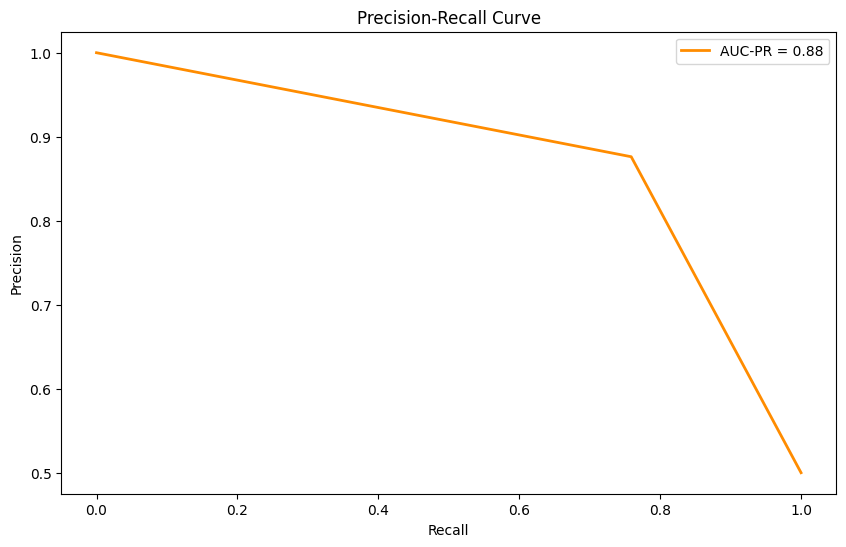

In [33]:
precision, recall, _ = precision_recall_curve(y_threshold, predictions)

# Calculate the area under the precision-recall curve (AUC-PR)
pr_auc = auc(recall, precision)

# Plot the precision-recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label=f'AUC-PR = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()


## TESTING ON DATA ##

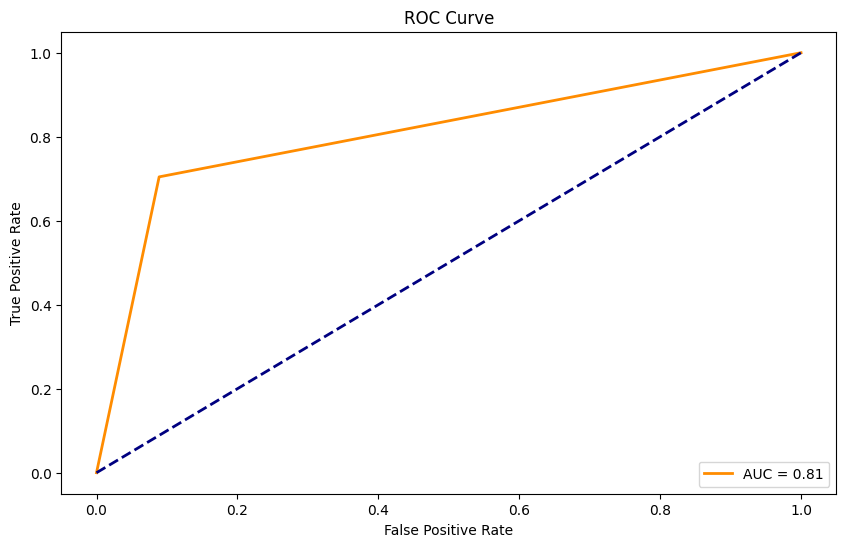

In [34]:
model.eval()
validation_losses = []
with torch.no_grad():
    for batch in test_loader:
        x_val = batch.to(device)
        x_val = x_val.view(-1, input_size)
        reconstruction_val, mu_val, log_var_val = model(x_val)
        validation_loss = model.compute_loss(reconstruction_val, x_val, mu_val, log_var_val, weight, kl_weight)
        validation_losses.append(validation_loss.item())




predictions = (validation_losses < optimal_threshold).astype(int)
fpr, tpr, threshold = roc_curve(y_test, predictions)

roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


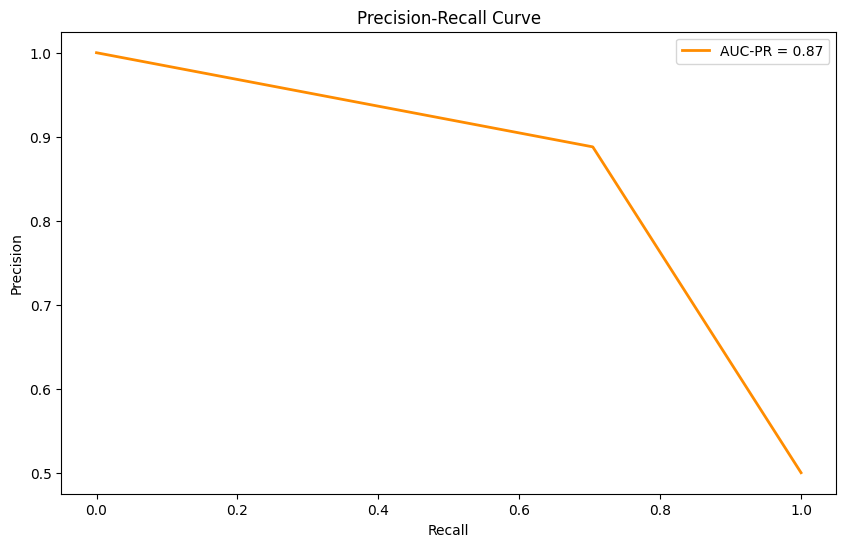

In [35]:
precision, recall, _ = precision_recall_curve(y_test, predictions)

# Calculate the area under the precision-recall curve (AUC-PR)
pr_auc = auc(recall, precision)

# Plot the precision-recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label=f'AUC-PR = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.show()
